In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import rubin_sim
import rubin_sim.maf as maf
#from rubin_sim.data import get_baseline
rubin_sim.__version__
from rubin_sim import maf
from os.path import splitext, basename

'1.3.3'

In [2]:
# new metrics
from uniformity_metrics import LinearMultibandModelMetric
from summary_metrics import FskyMetric, TotalPowerMetric
# needed for extracting depth maps in the first place
from rubin_sim.maf.metrics.weak_lensing_systematics_metric import ExgalM5WithCuts

/pscratch/sd/q/qhang/rubin_baseline_db/baseline_v3.3_10yrs.db baseline_v3.3_10yrs


In [ ]:
# this contains the current model.
# the first set of keys are the years (year1, ..., year10) since this would change typical depth and galaxy catalog cuts.
# in what follows we have 5 tomographic bins.
# the second nested dictionary has the following:
# sigma8square_model is the fiducial sigma8^2 value used in CCL for the theory predictions
# poly1d_coefs_loglog is a polynomial (5th degree) describing the angular power spectra (in log log space) in the 5 tomographic bins considered, thus has shape (5, 6)
# lmax contains the lmax limits to sum the Cells over when calculating sigma8 for each tomographic bin. thus is it of shape (5, )
# dlogN_dm5 contains the derivatives of logN wrt m5 calculated in Qianjun & Jeff's simulations. It is an array of 5 dictionaries (5 = the tomographic bins)
# each dictionary must have keys that are the lsst bands. If some are missing they are ignored in the linear model.
# they are the ones which will be fed to LinearMultibandModelMetric. Everything else above is going into the modeling 

# The notebook I used to make this dictionary is https://github.com/ixkael/ObsStrat/blob/meanz_uniformity_maf/code/meanz_uniformity/romanrubinmock_for_sigma8tomography.ipynb

In [3]:
density_tomography_model = {
    'year1': {
        'sigma8square_model': 0.8**2.0,
        'poly1d_coefs_loglog': np.array([[-7.94546823e-04,  2.62494452e-02, -2.27597655e-01,
         4.67266497e-01,  3.38850627e-01, -1.14120412e+01],
       [ 3.98978657e-04,  6.69012313e-03, -1.35005872e-01,
         3.72800783e-01,  3.97123211e-01, -1.29908869e+01],
       [ 1.03940293e-03, -5.18759967e-03, -6.85178825e-02,
         2.69468206e-01,  4.60031701e-01, -1.41217016e+01],
       [ 1.42986845e-03, -1.27862974e-02, -2.26263084e-02,
         1.85536763e-01,  5.12886349e-01, -1.48861030e+01],
       [ 1.73667255e-03, -1.89601890e-02,  1.80214246e-02,
         9.50637447e-02,  5.58980246e-01, -1.55053201e+01]]),
        'lmax': np.array([ 64,  94, 124, 146, 164]),
        'dlogN_dm5': [
        {'cst': 0.0, 'u': 0.043962974958662145, 'g': 0.043962974958662145, 'r': 0.043962974958662145, 'i': 0.043962974958662145, 'z': 0.043962974958662145, 'y': 0.043962974958662145, 'ugrizy': 0.043962974958662145},
        {'cst': 0.0, 'u': 0.034752650841693544, 'g': 0.034752650841693544, 'r': 0.034752650841693544, 'i': 0.034752650841693544, 'z': 0.034752650841693544, 'y': 0.034752650841693544, 'ugrizy': 0.034752650841693544},
        {'cst': 0.0, 'u': 0.033787326976188484, 'g': 0.033787326976188484, 'r': 0.033787326976188484, 'i': 0.033787326976188484, 'z': 0.033787326976188484, 'y': 0.033787326976188484, 'ugrizy': 0.033787326976188484},
        {'cst': 0.0, 'u': -0.058749555322422424, 'g': -0.058749555322422424, 'r': -0.058749555322422424, 'i': -0.058749555322422424, 'z': -0.058749555322422424, 'y': -0.058749555322422424, 'ugrizy': -0.058749555322422424},
        {'cst': 0.0, 'u': -0.08739685057046752, 'g': -0.08739685057046752, 'r': -0.08739685057046752, 'i': -0.08739685057046752, 'z': -0.08739685057046752, 'y': -0.08739685057046752, 'ugrizy': -0.08739685057046752},
        ],
    },
    'year2': {
        'sigma8square_model': 0.8**2.0,
        'poly1d_coefs_loglog': np.array([[-7.72116403e-04,  2.59654127e-02, -2.26957718e-01,
         4.69432713e-01,  3.39213385e-01, -1.13989048e+01],
       [ 4.22801028e-04,  6.36607807e-03, -1.34108644e-01,
         3.74841312e-01,  3.96986022e-01, -1.29600665e+01],
       [ 1.07354523e-03, -5.73388904e-03, -6.60135335e-02,
         2.67377905e-01,  4.62220942e-01, -1.40738990e+01],
       [ 1.46948747e-03, -1.34766061e-02, -1.89609170e-02,
         1.80340598e-01,  5.17052663e-01, -1.48679098e+01],
       [ 1.79954923e-03, -1.99827467e-02,  2.28427111e-02,
         9.06204330e-02,  5.69080814e-01, -1.55353679e+01]]),
        'lmax': np.array([ 64,  95, 123, 147, 166]),
        'dlogN_dm5': [
        {'cst': 0.0, 'u': 0.055492947394854004, 'g': 0.055492947394854004, 'r': 0.055492947394854004, 'i': 0.055492947394854004, 'z': 0.055492947394854004, 'y': 0.055492947394854004, 'ugrizy': 0.055492947394854004},
        {'cst': 0.0, 'u': 0.029608214159172044, 'g': 0.029608214159172044, 'r': 0.029608214159172044, 'i': 0.029608214159172044, 'z': 0.029608214159172044, 'y': 0.029608214159172044, 'ugrizy': 0.029608214159172044},
        {'cst': 0.0, 'u': 0.01704700362928206, 'g': 0.01704700362928206, 'r': 0.01704700362928206, 'i': 0.01704700362928206, 'z': 0.01704700362928206, 'y': 0.01704700362928206, 'ugrizy': 0.01704700362928206},
        {'cst': 0.0, 'u': -0.061409368487154156, 'g': -0.061409368487154156, 'r': -0.061409368487154156, 'i': -0.061409368487154156, 'z': -0.061409368487154156, 'y': -0.061409368487154156, 'ugrizy': -0.061409368487154156},
        {'cst': 0.0, 'u': -0.050114709867968066, 'g': -0.050114709867968066, 'r': -0.050114709867968066, 'i': -0.050114709867968066, 'z': -0.050114709867968066, 'y': -0.050114709867968066, 'ugrizy': -0.050114709867968066},
        ],
    },
    'year3': {
        'sigma8square_model': 0.8**2.0,
        'poly1d_coefs_loglog': np.array([[-7.47335451e-04,  2.55922442e-02, -2.25366760e-01,
         4.68243951e-01,  3.39807736e-01, -1.14004586e+01],
       [ 4.37952430e-04,  6.13359097e-03, -1.33135431e-01,
         3.74413364e-01,  3.97397465e-01, -1.29291594e+01],
       [ 1.08534795e-03, -5.92068724e-03, -6.51754697e-02,
         2.66734891e-01,  4.63243671e-01, -1.40474513e+01],
       [ 1.47812824e-03, -1.35845536e-02, -1.88487898e-02,
         1.82317694e-01,  5.17486035e-01, -1.48384185e+01],
       [ 1.82831353e-03, -2.03855872e-02,  2.40741011e-02,
         9.27502779e-02,  5.73850795e-01, -1.55657849e+01]]),
        'lmax': np.array([ 64,  94, 123, 147, 168]),
        'dlogN_dm5': [
        {'cst': 0.0, 'u': 0.04571336657551873, 'g': 0.04571336657551873, 'r': 0.04571336657551873, 'i': 0.04571336657551873, 'z': 0.04571336657551873, 'y': 0.04571336657551873, 'ugrizy': 0.04571336657551873},
        {'cst': 0.0, 'u': 0.03578384485292078, 'g': 0.03578384485292078, 'r': 0.03578384485292078, 'i': 0.03578384485292078, 'z': 0.03578384485292078, 'y': 0.03578384485292078, 'ugrizy': 0.03578384485292078},
        {'cst': 0.0, 'u': 0.023135003462698395, 'g': 0.023135003462698395, 'r': 0.023135003462698395, 'i': 0.023135003462698395, 'z': 0.023135003462698395, 'y': 0.023135003462698395, 'ugrizy': 0.023135003462698395},
        {'cst': 0.0, 'u': -0.05756589965508176, 'g': -0.05756589965508176, 'r': -0.05756589965508176, 'i': -0.05756589965508176, 'z': -0.05756589965508176, 'y': -0.05756589965508176, 'ugrizy': -0.05756589965508176},
        {'cst': 0.0, 'u': -0.025917249340435374, 'g': -0.025917249340435374, 'r': -0.025917249340435374, 'i': -0.025917249340435374, 'z': -0.025917249340435374, 'y': -0.025917249340435374, 'ugrizy': -0.025917249340435374},
        ],
    },
    'year4': {
        'sigma8square_model': 0.8**2.0,
        'poly1d_coefs_loglog': np.array([[-7.41568743e-04,  2.55297105e-02, -2.25339653e-01,
         4.69342516e-01,  3.39385437e-01, -1.13829013e+01],
       [ 4.47724999e-04,  5.99613130e-03, -1.32666973e-01,
         3.74708889e-01,  3.97389350e-01, -1.29064781e+01],
       [ 1.09566923e-03, -6.07450334e-03, -6.45513085e-02,
         2.66522400e-01,  4.63653700e-01, -1.40182124e+01],
       [ 1.48898237e-03, -1.37812174e-02, -1.77616026e-02,
         1.80633787e-01,  5.19149830e-01, -1.48277616e+01],
       [ 1.84812024e-03, -2.07364151e-02,  2.60418879e-02,
         8.93719930e-02,  5.77645934e-01, -1.55728084e+01]]),
        'lmax': np.array([ 63,  94, 123, 148, 169]),
        'dlogN_dm5': [
        {'cst': 0.0, 'u': 0.054293436011708406, 'g': 0.054293436011708406, 'r': 0.054293436011708406, 'i': 0.054293436011708406, 'z': 0.054293436011708406, 'y': 0.054293436011708406, 'ugrizy': 0.054293436011708406},
        {'cst': 0.0, 'u': 0.034776420860264834, 'g': 0.034776420860264834, 'r': 0.034776420860264834, 'i': 0.034776420860264834, 'z': 0.034776420860264834, 'y': 0.034776420860264834, 'ugrizy': 0.034776420860264834},
        {'cst': 0.0, 'u': 0.023084985340137268, 'g': 0.023084985340137268, 'r': 0.023084985340137268, 'i': 0.023084985340137268, 'z': 0.023084985340137268, 'y': 0.023084985340137268, 'ugrizy': 0.023084985340137268},
        {'cst': 0.0, 'u': -0.056015513609789944, 'g': -0.056015513609789944, 'r': -0.056015513609789944, 'i': -0.056015513609789944, 'z': -0.056015513609789944, 'y': -0.056015513609789944, 'ugrizy': -0.056015513609789944},
        {'cst': 0.0, 'u': -0.02151012665531872, 'g': -0.02151012665531872, 'r': -0.02151012665531872, 'i': -0.02151012665531872, 'z': -0.02151012665531872, 'y': -0.02151012665531872, 'ugrizy': -0.02151012665531872},
        ],
    },
    'year5': {
        'sigma8square_model': 0.8**2.0,
        'poly1d_coefs_loglog': np.array([[-7.35347360e-04,  2.54490508e-02, -2.25123057e-01,
         4.69736089e-01,  3.39586115e-01, -1.13755955e+01],
       [ 4.53471097e-04,  5.90580865e-03, -1.32288337e-01,
         3.74594679e-01,  3.97577407e-01, -1.29025614e+01],
       [ 1.10564516e-03, -6.23727532e-03, -6.37987371e-02,
         2.65929839e-01,  4.64485800e-01, -1.40110253e+01],
       [ 1.49887589e-03, -1.39372292e-02, -1.70839226e-02,
         1.80323328e-01,  5.19727794e-01, -1.47989678e+01],
       [ 1.87614685e-03, -2.11800406e-02,  2.81877828e-02,
         8.68286284e-02,  5.79267039e-01, -1.55754670e+01]]),
        'lmax': np.array([ 63,  95, 123, 148, 169]),
        'dlogN_dm5': [
        {'cst': 0.0, 'u': 0.049239020937134025, 'g': 0.049239020937134025, 'r': 0.049239020937134025, 'i': 0.049239020937134025, 'z': 0.049239020937134025, 'y': 0.049239020937134025, 'ugrizy': 0.049239020937134025},
        {'cst': 0.0, 'u': 0.03635061259366789, 'g': 0.03635061259366789, 'r': 0.03635061259366789, 'i': 0.03635061259366789, 'z': 0.03635061259366789, 'y': 0.03635061259366789, 'ugrizy': 0.03635061259366789},
        {'cst': 0.0, 'u': 0.018654370753291738, 'g': 0.018654370753291738, 'r': 0.018654370753291738, 'i': 0.018654370753291738, 'z': 0.018654370753291738, 'y': 0.018654370753291738, 'ugrizy': 0.018654370753291738},
        {'cst': 0.0, 'u': -0.057050518892029986, 'g': -0.057050518892029986, 'r': -0.057050518892029986, 'i': -0.057050518892029986, 'z': -0.057050518892029986, 'y': -0.057050518892029986, 'ugrizy': -0.057050518892029986},
        {'cst': 0.0, 'u': -0.022746170354716745, 'g': -0.022746170354716745, 'r': -0.022746170354716745, 'i': -0.022746170354716745, 'z': -0.022746170354716745, 'y': -0.022746170354716745, 'ugrizy': -0.022746170354716745},
        ],
    },
    'year6': {
        'sigma8square_model': 0.8**2.0,
        'poly1d_coefs_loglog': np.array([[-7.29402173e-04,  2.53591187e-02, -2.24744974e-01,
         4.69511416e-01,  3.39616928e-01, -1.13734220e+01],
       [ 4.57098537e-04,  5.86340062e-03, -1.32257952e-01,
         3.75362916e-01,  3.97431135e-01, -1.28861252e+01],
       [ 1.10975980e-03, -6.30581393e-03, -6.34236372e-02,
         2.65250360e-01,  4.64594967e-01, -1.39905973e+01],
       [ 1.50470306e-03, -1.40535883e-02, -1.63140359e-02,
         1.78531058e-01,  5.20616617e-01, -1.47817593e+01],
       [ 1.87684022e-03, -2.11967381e-02,  2.82475769e-02,
         8.70224981e-02,  5.80844971e-01, -1.55660655e+01]]),
        'lmax': np.array([ 63,  94, 123, 147, 169]),
        'dlogN_dm5': [
        {'cst': 0.0, 'u': 0.04731277533039653, 'g': 0.04731277533039653, 'r': 0.04731277533039653, 'i': 0.04731277533039653, 'z': 0.04731277533039653, 'y': 0.04731277533039653, 'ugrizy': 0.04731277533039653},
        {'cst': 0.0, 'u': 0.03307274442076383, 'g': 0.03307274442076383, 'r': 0.03307274442076383, 'i': 0.03307274442076383, 'z': 0.03307274442076383, 'y': 0.03307274442076383, 'ugrizy': 0.03307274442076383},
        {'cst': 0.0, 'u': 0.02629040528053873, 'g': 0.02629040528053873, 'r': 0.02629040528053873, 'i': 0.02629040528053873, 'z': 0.02629040528053873, 'y': 0.02629040528053873, 'ugrizy': 0.02629040528053873},
        {'cst': 0.0, 'u': -0.051460395769436555, 'g': -0.051460395769436555, 'r': -0.051460395769436555, 'i': -0.051460395769436555, 'z': -0.051460395769436555, 'y': -0.051460395769436555, 'ugrizy': -0.051460395769436555},
        {'cst': 0.0, 'u': -0.0231010021253421, 'g': -0.0231010021253421, 'r': -0.0231010021253421, 'i': -0.0231010021253421, 'z': -0.0231010021253421, 'y': -0.0231010021253421, 'ugrizy': -0.0231010021253421},
        ],
    },
    'year7': {
        'sigma8square_model': 0.8**2.0,
        'poly1d_coefs_loglog': np.array([[-7.18947651e-04,  2.52048402e-02, -2.24128689e-01,
         4.69247373e-01,  3.39996105e-01, -1.13691749e+01],
       [ 4.66194938e-04,  5.71142011e-03, -1.31505217e-01,
         3.74462215e-01,  3.97920687e-01, -1.28754286e+01],
       [ 1.11096134e-03, -6.32112700e-03, -6.34065660e-02,
         2.65513757e-01,  4.64794474e-01, -1.39828608e+01],
       [ 1.50696925e-03, -1.40997435e-02, -1.60608483e-02,
         1.78259845e-01,  5.21324331e-01, -1.47778620e+01],
       [ 1.89997066e-03, -2.16155858e-02,  3.08453940e-02,
         8.11771421e-02,  5.82883411e-01, -1.55574865e+01]]),
        'lmax': np.array([ 63,  94, 123, 148, 170]),
        'dlogN_dm5': [
        {'cst': 0.0, 'u': 0.04691474328780031, 'g': 0.04691474328780031, 'r': 0.04691474328780031, 'i': 0.04691474328780031, 'z': 0.04691474328780031, 'y': 0.04691474328780031, 'ugrizy': 0.04691474328780031},
        {'cst': 0.0, 'u': 0.02926172329832247, 'g': 0.02926172329832247, 'r': 0.02926172329832247, 'i': 0.02926172329832247, 'z': 0.02926172329832247, 'y': 0.02926172329832247, 'ugrizy': 0.02926172329832247},
        {'cst': 0.0, 'u': 0.024028335574766118, 'g': 0.024028335574766118, 'r': 0.024028335574766118, 'i': 0.024028335574766118, 'z': 0.024028335574766118, 'y': 0.024028335574766118, 'ugrizy': 0.024028335574766118},
        {'cst': 0.0, 'u': -0.05102903641687596, 'g': -0.05102903641687596, 'r': -0.05102903641687596, 'i': -0.05102903641687596, 'z': -0.05102903641687596, 'y': -0.05102903641687596, 'ugrizy': -0.05102903641687596},
        {'cst': 0.0, 'u': -0.026688237135998293, 'g': -0.026688237135998293, 'r': -0.026688237135998293, 'i': -0.026688237135998293, 'z': -0.026688237135998293, 'y': -0.026688237135998293, 'ugrizy': -0.026688237135998293},
        ],
    },
    'year8': {
        'sigma8square_model': 0.8**2.0,
        'poly1d_coefs_loglog': np.array([[-7.20978717e-04,  2.52386810e-02, -2.24297998e-01,
         4.69472361e-01,  3.39895949e-01, -1.13578618e+01],
       [ 4.67843599e-04,  5.69127210e-03, -1.31454331e-01,
         3.74573469e-01,  3.97784625e-01, -1.28655285e+01],
       [ 1.11711699e-03, -6.42150038e-03, -6.29326395e-02,
         2.65065150e-01,  4.65281866e-01, -1.39739921e+01],
       [ 1.51463261e-03, -1.42349222e-02, -1.53268735e-02,
         1.77158327e-01,  5.22084943e-01, -1.47629374e+01],
       [ 1.89029193e-03, -2.14244957e-02,  2.94913874e-02,
         8.48496470e-02,  5.82823818e-01, -1.55582137e+01]]),
        'lmax': np.array([ 63,  94, 123, 148, 170]),
        'dlogN_dm5': [
        {'cst': 0.0, 'u': 0.04786137493054727, 'g': 0.04786137493054727, 'r': 0.04786137493054727, 'i': 0.04786137493054727, 'z': 0.04786137493054727, 'y': 0.04786137493054727, 'ugrizy': 0.04786137493054727},
        {'cst': 0.0, 'u': 0.03327254021698463, 'g': 0.03327254021698463, 'r': 0.03327254021698463, 'i': 0.03327254021698463, 'z': 0.03327254021698463, 'y': 0.03327254021698463, 'ugrizy': 0.03327254021698463},
        {'cst': 0.0, 'u': 0.02176497146894746, 'g': 0.02176497146894746, 'r': 0.02176497146894746, 'i': 0.02176497146894746, 'z': 0.02176497146894746, 'y': 0.02176497146894746, 'ugrizy': 0.02176497146894746},
        {'cst': 0.0, 'u': -0.0542981307448116, 'g': -0.0542981307448116, 'r': -0.0542981307448116, 'i': -0.0542981307448116, 'z': -0.0542981307448116, 'y': -0.0542981307448116, 'ugrizy': -0.0542981307448116},
        {'cst': 0.0, 'u': -0.02285214586340533, 'g': -0.02285214586340533, 'r': -0.02285214586340533, 'i': -0.02285214586340533, 'z': -0.02285214586340533, 'y': -0.02285214586340533, 'ugrizy': -0.02285214586340533},
        ],
    },
    'year9': {
        'sigma8square_model': 0.8**2.0,
        'poly1d_coefs_loglog': np.array([[-7.23432734e-04,  2.52943590e-02, -2.24707794e-01,
         4.70555869e-01,  3.39390877e-01, -1.13448965e+01],
       [ 4.68298841e-04,  5.69359050e-03, -1.31559784e-01,
         3.75124408e-01,  3.97498952e-01, -1.28555902e+01],
       [ 1.11687532e-03, -6.40919987e-03, -6.30785495e-02,
         2.65647380e-01,  4.64932561e-01, -1.39661254e+01],
       [ 1.51771172e-03, -1.42863837e-02, -1.50790664e-02,
         1.76934887e-01,  5.22416665e-01, -1.47607945e+01],
       [ 1.90353259e-03, -2.16360592e-02,  3.05135359e-02,
         8.36649036e-02,  5.84231771e-01, -1.55657045e+01]]),
        'lmax': np.array([ 63,  94, 123, 148, 170]),
        'dlogN_dm5': [
        {'cst': 0.0, 'u': 0.044390298549263456, 'g': 0.044390298549263456, 'r': 0.044390298549263456, 'i': 0.044390298549263456, 'z': 0.044390298549263456, 'y': 0.044390298549263456, 'ugrizy': 0.044390298549263456},
        {'cst': 0.0, 'u': 0.024830399951491312, 'g': 0.024830399951491312, 'r': 0.024830399951491312, 'i': 0.024830399951491312, 'z': 0.024830399951491312, 'y': 0.024830399951491312, 'ugrizy': 0.024830399951491312},
        {'cst': 0.0, 'u': 0.022781496880732575, 'g': 0.022781496880732575, 'r': 0.022781496880732575, 'i': 0.022781496880732575, 'z': 0.022781496880732575, 'y': 0.022781496880732575, 'ugrizy': 0.022781496880732575},
        {'cst': 0.0, 'u': -0.04816414607472254, 'g': -0.04816414607472254, 'r': -0.04816414607472254, 'i': -0.04816414607472254, 'z': -0.04816414607472254, 'y': -0.04816414607472254, 'ugrizy': -0.04816414607472254},
        {'cst': 0.0, 'u': -0.024440454014018773, 'g': -0.024440454014018773, 'r': -0.024440454014018773, 'i': -0.024440454014018773, 'z': -0.024440454014018773, 'y': -0.024440454014018773, 'ugrizy': -0.024440454014018773},
        ],
    },
    'year10': {
        'sigma8square_model': 0.8**2.0,
        'poly1d_coefs_loglog': np.array([[-7.16061620e-04,  2.51744502e-02, -2.24107456e-01,
         4.69700181e-01,  3.39695775e-01, -1.13492481e+01],
       [ 4.69488083e-04,  5.67705574e-03, -1.31512276e-01,
         3.75205008e-01,  3.97691903e-01, -1.28530855e+01],
       [ 1.11838359e-03, -6.43543666e-03, -6.29190558e-02,
         2.65259815e-01,  4.65238973e-01, -1.39566261e+01],
       [ 1.52245292e-03, -1.43703455e-02, -1.45911836e-02,
         1.75990818e-01,  5.22698913e-01, -1.47457598e+01],
       [ 1.92138091e-03, -2.19184749e-02,  3.20303750e-02,
         8.07319417e-02,  5.85683971e-01, -1.55499003e+01]]),
        'lmax': np.array([ 63,  95, 123, 148, 170]),
        'dlogN_dm5': [
        {'cst': 0.0, 'u': 0.05535070282190964, 'g': 0.05535070282190964, 'r': 0.05535070282190964, 'i': 0.05535070282190964, 'z': 0.05535070282190964, 'y': 0.05535070282190964, 'ugrizy': 0.05535070282190964},
        {'cst': 0.0, 'u': 0.029973080589983655, 'g': 0.029973080589983655, 'r': 0.029973080589983655, 'i': 0.029973080589983655, 'z': 0.029973080589983655, 'y': 0.029973080589983655, 'ugrizy': 0.029973080589983655},
        {'cst': 0.0, 'u': 0.02262813226603151, 'g': 0.02262813226603151, 'r': 0.02262813226603151, 'i': 0.02262813226603151, 'z': 0.02262813226603151, 'y': 0.02262813226603151, 'ugrizy': 0.02262813226603151},
        {'cst': 0.0, 'u': -0.046678413257774214, 'g': -0.046678413257774214, 'r': -0.046678413257774214, 'i': -0.046678413257774214, 'z': -0.046678413257774214, 'y': -0.046678413257774214, 'ugrizy': -0.046678413257774214},
        {'cst': 0.0, 'u': -0.025182273951223154, 'g': -0.025182273951223154, 'r': -0.025182273951223154, 'i': -0.025182273951223154, 'z': -0.025182273951223154, 'y': -0.025182273951223154, 'ugrizy': -0.025182273951223154},
        ],
    },
}

In [ ]:
def solve_for_multiplicative_factor(spurious_powers, model_cells, fskys, lmin, percentage_uncorrected):
    # solve for multiplicative sigma8^2 term between
    # measured angular power spectra (spurious measured Cells times percentage_uncorrected)
    # and model ones (polynomial model from CCL).
    n_bins = model_cells['lmax'].size
    assert len(spurious_powers) == n_bins
    assert len(fskys) == n_bins
    assert model_cells['poly1d_coefs_loglog'].shape[0] == n_bins
    totalvar_mod = np.zeros((n_bins, 1))
    totalvar_obs = np.zeros((n_bins, 1))
    totalvar_var = np.zeros((n_bins, 1))
    transfers = np.zeros((n_bins, 1))
    # loop over tomographic bins
    sigma8square_model = model_cells['sigma8square_model'] # hardcoded; assumed CCL cosmology
    for i in range(n_bins):

        # get model Cells from polynomial model (in log log space)
        ells = np.arange(lmin, model_cells['lmax'][i])
        polynomial_model = np.poly1d(model_cells['poly1d_coefs_loglog'][i, :])
        cells_model = np.exp(polynomial_model(np.log(ells)))

        # model variance is sum of cells x (2l+1)
        totalvar_mod[i, 0] = np.sum(cells_model * (2*ells + 1))   

        # observations is spurious power  noiseless model 
        totalvar_obs[i, 0] = totalvar_mod[i, 0] + spurious_powers[i] * percentage_uncorrected

        # simple model variance of cell baased on Gaussian covariance
        cells_var = 2 * cells_model ** 2 / (2*ells + 1) / fskys[i]
        totalvar_var[i, 0] = np.sum(cells_var * (2*ells + 1)**2)

    # model assumed sigma8 = 0.8 (add CCL cosmology here? or how I obtained them + documentation
    
    results_fractional_spurious_power = totalvar_obs / totalvar_mod - 1.0 

    transfers = totalvar_mod / sigma8square_model # model Cell variance divided by sigma8^2, which is the common normalization
    
    # model ratio: formula for posterior distribution on unknown multiplicative factor in multivariate Gaussian likelihood
    FOT = np.sum(transfers[:, 0] * totalvar_obs[:, 0] / totalvar_var[:, 0])
    FTT = np.sum(transfers[:, 0] * transfers[:, 0] / totalvar_var[:, 0])
    # mean and stddev of multiplicative factor
    sigma8squared_fit = FOT / FTT
    sigma8squared_error = FTT ** -0.5
    
    return sigma8squared_fit, sigma8squared_error, sigma8square_model

In [ ]:
def extract_sigma8_tomography_metric(
    opsim_fname, run_fname,
    years, 
    percentage_uncorrected,
    density_tomography_model, 
    lmin = 10,
    mag_range_tolerated=1.0,
    n_filters = 6, extinction_cut = 0.2, # sky cuts
    nside=32,
    plot_maps=True
):
    slicer = maf.HealpixSubsetSlicer(nside=nside, hpid=np.arange(hp.nside2npix(nside)), use_cache=False)
    
    # prepare empty arrays to fill in the results
    n_bins = 5
    results_spuriousdensitypower = np.zeros((len(years), n_bins))
    results_fsky = np.zeros((len(years), n_bins))
    results_sigma8_squared_bias = np.zeros((len(years), ))
    # loop over years 
    for iy, year in enumerate(years):
        print('year', year)
        
        # constraints
        days = year*365.25
        constraint_str = 'note not like "DD%" and night <= XX and note not like "twilight_near_sun" '
        constraint_str = constraint_str.replace('XX','%d'%days)

        ##############################
        # need to get mean depths first
        ##############################
        # I couldn't work out how to do this within the other metrics, since it needs to run over all data slices first
        # any suggestions welcome!
        depth_map_bundles = []
        for lsst_filter in ["u", "g", "r", "i", "z", "y"]: # loop over filters

            metric = ExgalM5WithCuts(
                extinction_cut=extinction_cut, depth_cut=23.0, n_filters=n_filters, # sky cuts
                lsst_filter=lsst_filter, # choice of filter
                metric_name='ExgalM5WithCuts_'+lsst_filter
            )
            # then standard way of packing MetricBundles into a MetricBundleGroup
            depth_map_bundles.append(maf.MetricBundle(
                metric=metric, slicer=slicer, 
                constraint=constraint_str, 
                run_name=run_name+lsst_filter
            ))
        bd = maf.metricBundles.make_bundles_dict_from_list(depth_map_bundles)
        bgroup = maf.MetricBundleGroup(bd, opsim_fname)
        bgroup.run_all()


        # store the result in a dict
        if plot_maps:
            plt.figure(figsize=(10, 10))
        mean_depth = {}
        min_depth_cut = {}
        max_depth_cut = {}
        for b, lsst_filter in enumerate(["u", "g", "r", "i", "z", "y"]):
            mean_depth[lsst_filter] = np.nanmean(depth_map_bundles[b].metric_values) # could use the summary metric instead
            min_depth_cut[lsst_filter] = mean_depth[lsst_filter] - mag_range_tolerated/2.0
            max_depth_cut[lsst_filter] = mean_depth[lsst_filter] + mag_range_tolerated/2.0
            #print(np.nanpercentile(depth_map_bundles[b].metric_values[~depth_map_bundles[b].metric_values.mask], [1, 5]))
            if plot_maps:
                hp.mollview(
                    depth_map_bundles[b].metric_values - mean_depth[lsst_filter], 
                    sub=int('32'+str(b+1)), 
                    min=min_depth_cut[lsst_filter]-mean_depth[lsst_filter], 
                    max=max_depth_cut[lsst_filter]-mean_depth[lsst_filter],
                    title=f"M5 depth fluctuations in {lsst_filter} (mean=%1.3f"%mean_depth[lsst_filter]+")"
                ) # in case see the mean
        print('mean depths:', mean_depth)

        
        ##############################
        # now converts depth fluctuations to density fluctuations
        ##############################
        depth_map_bundles = []
        for i in range(n_bins): # loop over redshift bins this time

            metric = LinearMultibandModelMetric(
                #overdensity_tomography_ddelta_dm5[i]['year'+str(year)], # model parameters
                density_tomography_model['year'+str(year)]['dlogN_dm5'][i],# post_processing_fn=lambda x : np.exp(x), # 
                extinction_cut=extinction_cut, n_filters=n_filters, # cuts going into ExgalM5WithCuts
                mean_depth=mean_depth, min_depth_cut=min_depth_cut, max_depth_cut=max_depth_cut,
                metric_name='LinearMultibandModel_bin'+str(i)
            )
            # summary metric measures total power via angular power spectra of healpix map (thus needs nside)
            # _but_ has a bin-dependent lmax to consider same scales to consider the same scales as a fct of redshift
            summary_metrics = [
                TotalPowerMetric(lmin=lmin, lmax=density_tomography_model['year'+str(year)]['lmax'][i], metric_name='TotalPower_bin'+str(i), mask_val=hp.UNSEEN),
                FskyMetric(metric_name='FootprintFraction_bin'+str(i))
                ## also needed the fraction of sky covered (under the cuts applied), but I couldn't get FootprintFractionMetric to work propertly for this purpose
            ]
            # then standard way of packing MetricBundles into a MetricBundleGroup
            depth_map_bundles.append(maf.MetricBundle(
                metric=metric,
                slicer=slicer,
                constraint=constraint_str,
                run_name=run_name+str(i),
                summary_metrics=summary_metrics
            ))
        bd = maf.metricBundles.make_bundles_dict_from_list(depth_map_bundles)
        bgroup = maf.MetricBundleGroup(bd, opsim_fname)
        bgroup.run_all()

        # store results
        if plot_maps:
            plt.figure(figsize=(10, 10))
        for i in range(n_bins):
            if plot_maps:
                hp.mollview(depth_map_bundles[i].metric_values, title='density fluctuations in redshift bin '+str(i), sub=int('32'+str(i+1))) # in case see the mean
            results_fsky[iy, i] = depth_map_bundles[i].summary_values['FootprintFraction_bin'+str(i)]
            results_spuriousdensitypower[iy, i] = depth_map_bundles[i].summary_values['TotalPower_bin'+str(i)] / results_fsky[iy, i] 
            # division by sky fraction insures this is (approximately) the power on the full sky

            
        # solve_for_multiplicative_factor, i.e. sigma8^2  low
        sigma8squared_fit, sigma8squared_error, sigma8square_model = solve_for_multiplicative_factor(
            results_spuriousdensitypower[iy, :], density_tomography_model['year'+str(year)], results_fsky[iy, :], lmin, percentage_uncorrected) 
        
        # compute bias
        results_sigma8_squared_bias[iy] = (sigma8squared_fit - sigma8square_model) / sigma8squared_error

    return results_fsky, results_sigma8_squared_bias

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
year 1


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 32 different from map value 128, using slicer value
  warnings.warn(


mean depths: {'u': 24.00643937223077, 'g': 25.400593501409386, 'r': 25.59424656509549, 'i': 25.212595317703197, 'z': 24.476267176026024, 'y': 23.657023463534685}


/global/u1/b/bleis89/ObsStrat/code/meanz_uniformity/summary_metrics.py:251: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  data = hp.remove_monopole(data, verbose=False, bad=self.mask_val)
/global/u1/b/bleis89/ObsStrat/code/meanz_uniformity/summary_metrics.py:253: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  data = hp.remove_dipole(data, verbose=False, bad=self.mask_val)


year 2
mean depths: {'u': 24.22026110769398, 'g': 25.740713869239467, 'r': 25.941861501013953, 'i': 25.54947332339745, 'z': 24.84711722348341, 'y': 23.993043440454077}
year 4
mean depths: {'u': 24.583261982302133, 'g': 26.13286560760831, 'r': 26.326701530892926, 'i': 25.903853962209332, 'z': 25.217145306789092, 'y': 24.327257276320267}


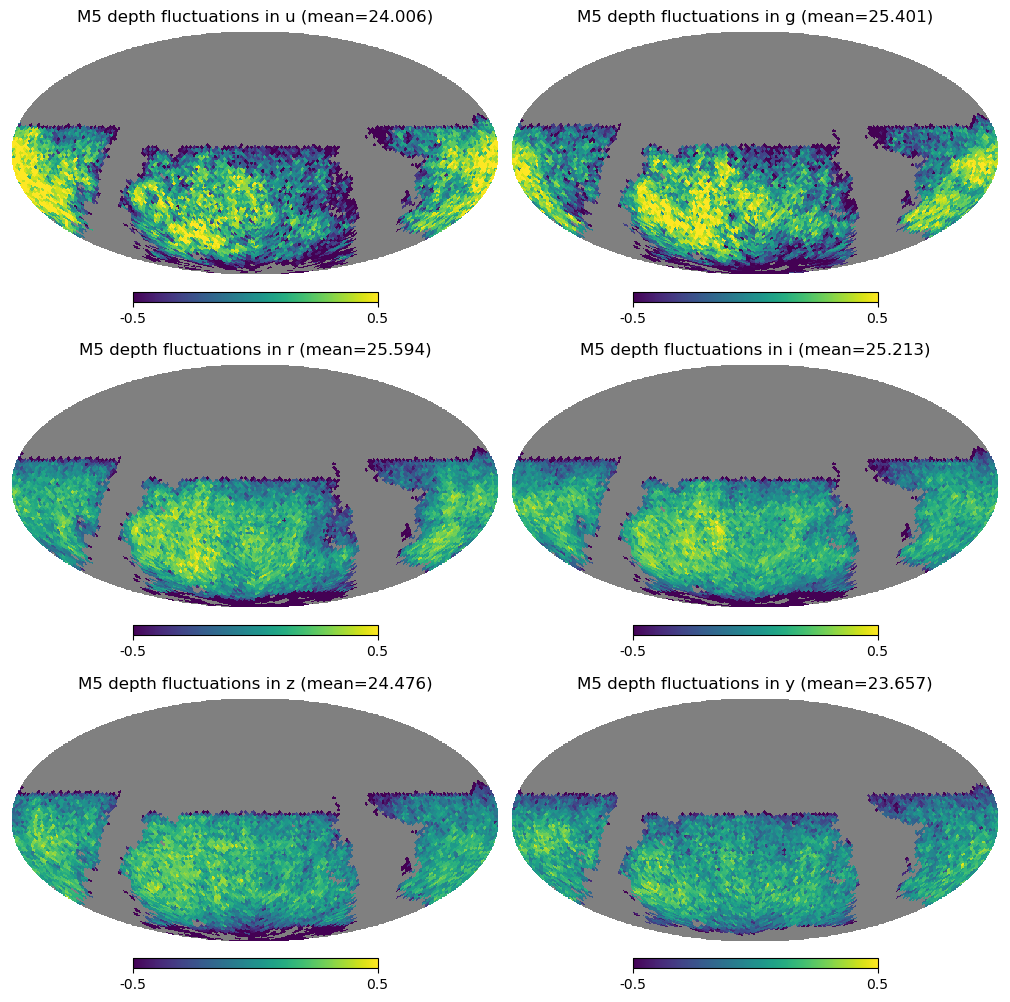

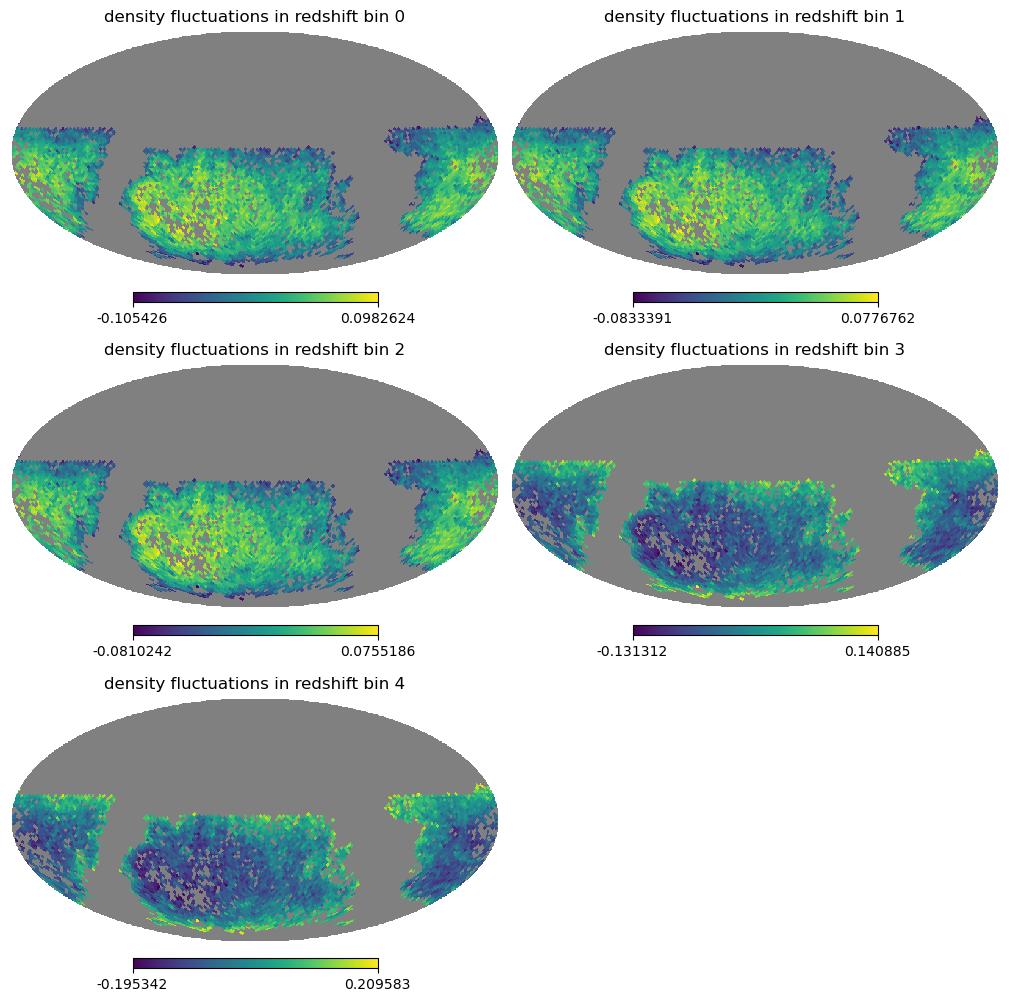

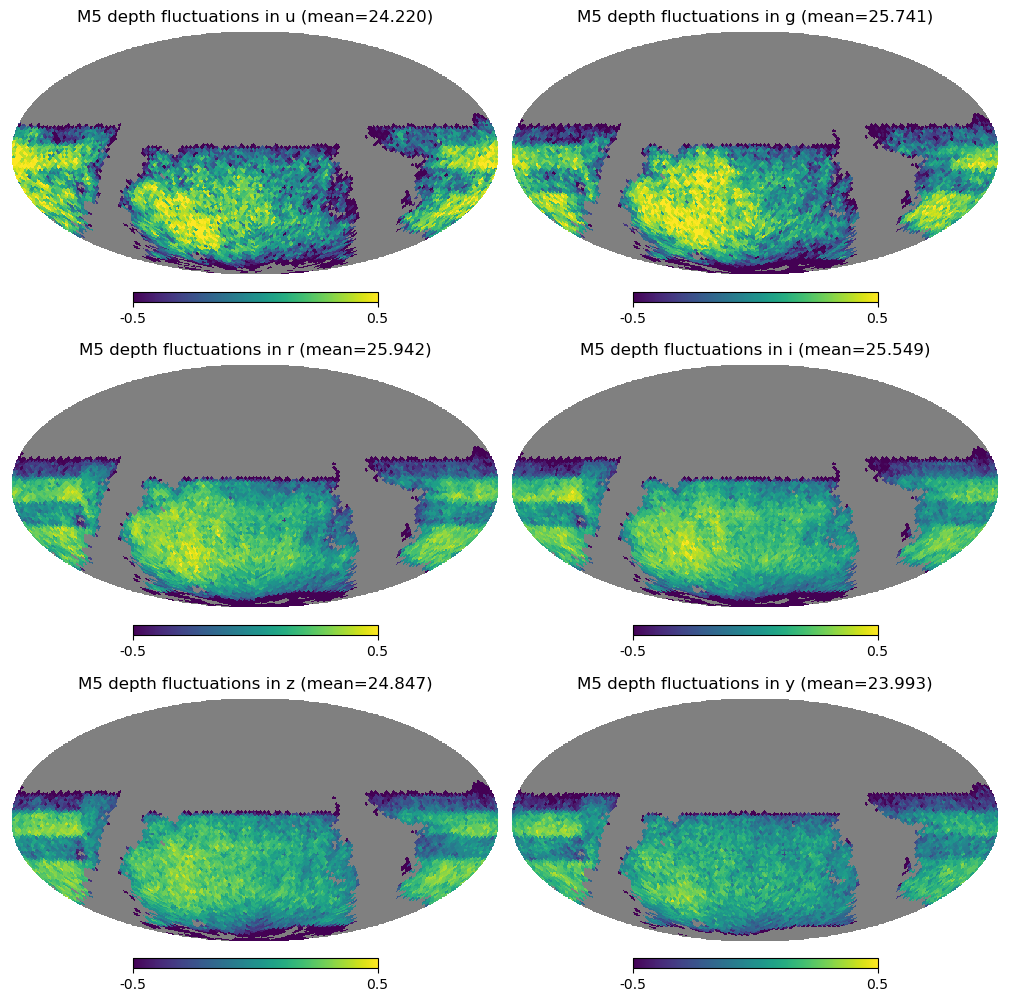

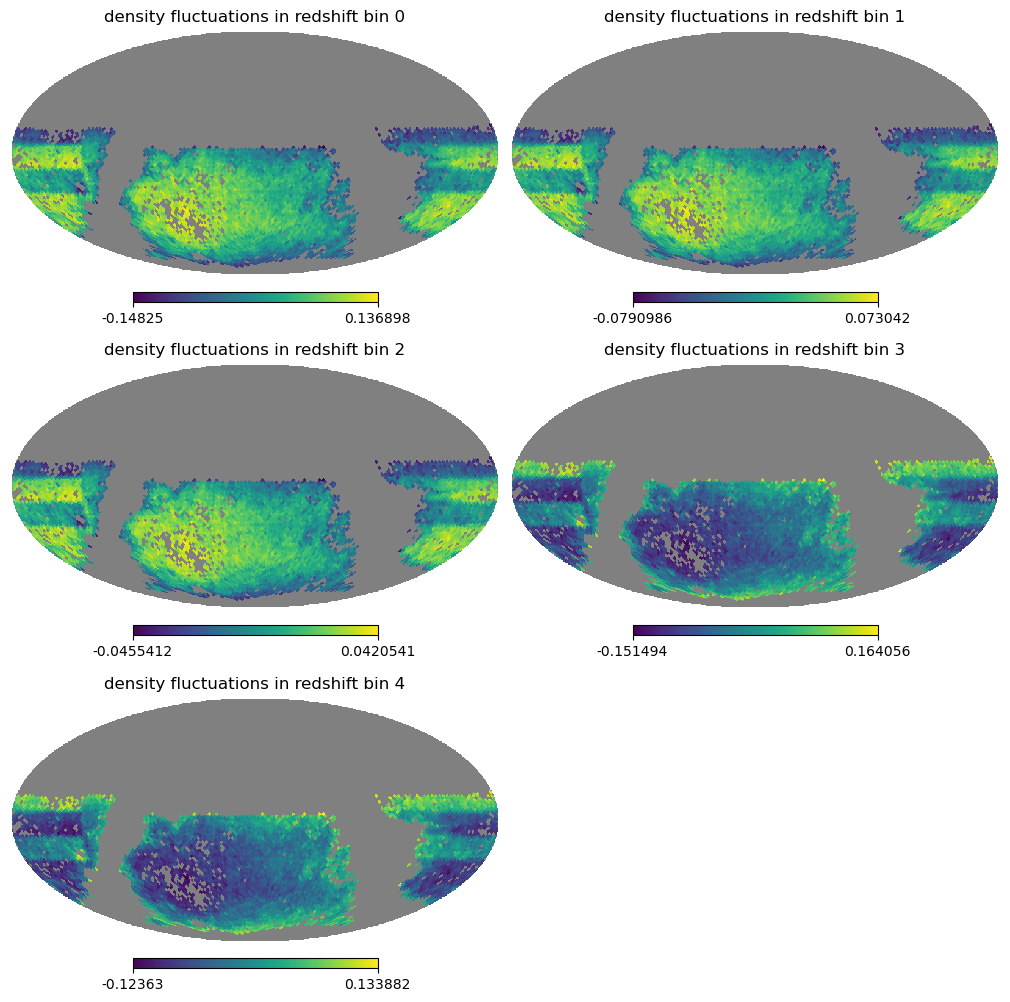

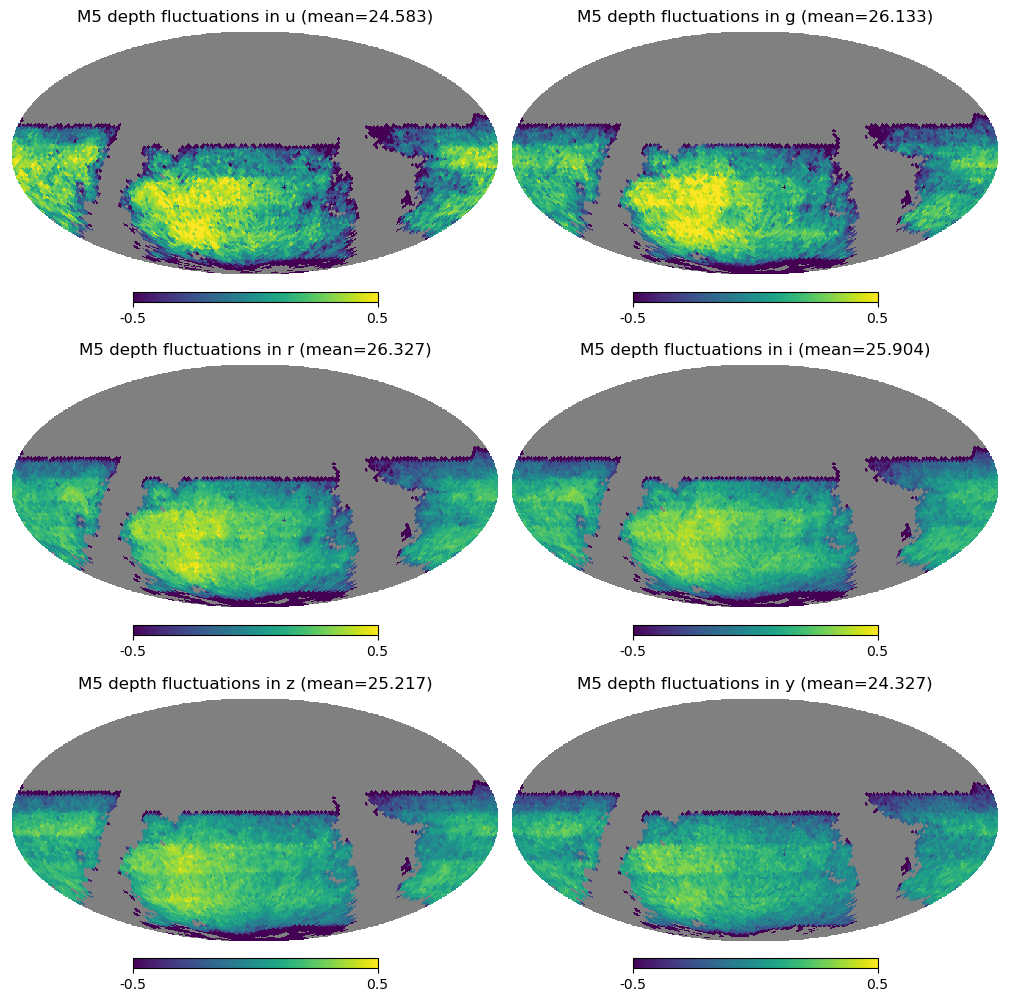

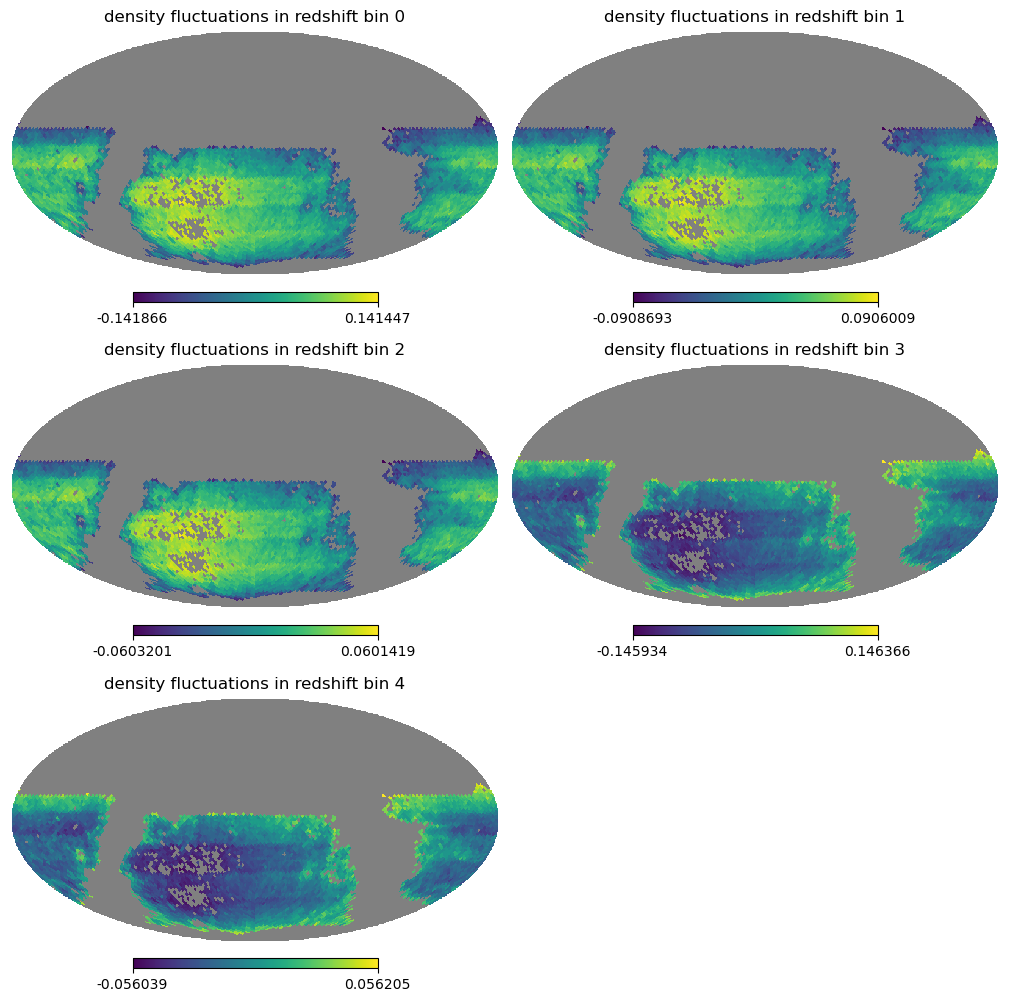

In [7]:
opsim_fname = "/pscratch/sd/q/qhang/rubin_baseline_db/baseline_v3.3_10yrs.db"
run_name = splitext(basename(opsim_fname))[0]
print(opsim_fname, run_name)

percentage_uncorrected = 0.1

years = [1, 2, 4]

results_fsky, results_sigma8_squared_bias = extract_sigma8_tomography_metric(
    opsim_fname, run_name,
    years, 
    percentage_uncorrected,
    density_tomography_model,
    mag_range_tolerated=1.0,
    nside=32,
    lmin = 10, n_filters = 6, extinction_cut = 0.2, plot_maps=True
)

In [30]:
%rm /global/homes/b/bleis89/ObsStrat/code/meanz_uniformity/*.npz

rm: cannot remove ‘/global/homes/b/bleis89/ObsStrat/code/meanz_uniformity/*.npz’: No such file or directory


In [32]:
sim_list = ['/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db',
               '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db',
               '/pscratch/sd/b/beckermr/v3.4_sims_rubin/roll_uniform_mjdp0_v3.4_10yrs.db',
               '/pscratch/sd/b/beckermr/v3.4_sims_rubin/baseline_v3.4_10yrs.db']
name_list = [splitext(basename(sim))[0] for sim in sim_list]

years = range(1, 11) 
percentage_uncorrected = 0.1

results_fsky = {}
results_sigma8_squared_bias = {}
for opsim_fname, run_name in zip(sim_list, name_list):
    
    print('run_name:', run_name)
    results_fsky[run_name], results_sigma8_squared_bias[run_name] = extract_sigma8_tomography_metric(
        opsim_fname, run_name,
        years, 
        percentage_uncorrected,
        density_tomography_model,
        nside=64,
        lmin=10, n_filters=6, extinction_cut=0.2, mag_range_tolerated=2.0,
        plot_maps=False
    )
    
    

run_name: baseline_v3.3_10yrs
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
year 1


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


mean depths: {'u': 23.999173231076973, 'g': 25.362195108872452, 'r': 25.557849976220393, 'i': 25.17327036677305, 'z': 24.459456484980215, 'y': 23.628854908935434}
year 2
mean depths: {'u': 24.23869114786449, 'g': 25.70977883896248, 'r': 25.932834408206393, 'i': 25.524506398532516, 'z': 24.825443670297336, 'y': 23.96337522003962}
year 3
mean depths: {'u': 24.44291682933271, 'g': 25.984394219203214, 'r': 26.17946254196321, 'i': 25.75016392897816, 'z': 25.051684927512877, 'y': 24.168873059255887}
year 4
mean depths: {'u': 24.582647682950114, 'g': 26.125873459891363, 'r': 26.319388766255393, 'i': 25.887348074454806, 'z': 25.199898775990345, 'y': 24.31500929638451}
year 5
mean depths: {'u': 24.682761622587865, 'g': 26.209817377729237, 'r': 26.40051188157291, 'i': 25.969508621481932, 'z': 25.290617751527513, 'y': 24.396730015975375}
year 6
mean depths: {'u': 24.76754818138692, 'g': 26.29204288315608, 'r': 26.48154705315129, 'i': 26.046900459300502, 'z': 25.375459095451696, 'y': 24.4714772089

Text(0, 0.5, 'Same minus baseline_v3.3_10yrs')

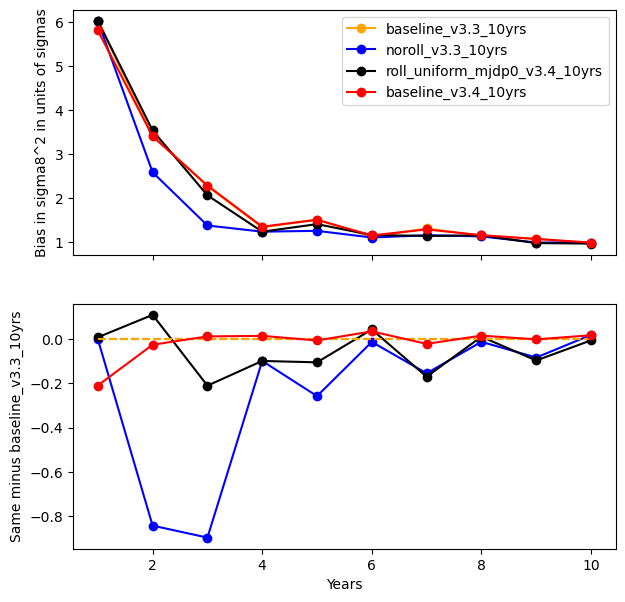

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

colors = ['orange', 'blue', 'black', 'red']
for i, run_name in enumerate(results_sigma8_squared_bias.keys()):
    axs[0].plot(years, results_sigma8_squared_bias[run_name], label=run_name, marker='o', color=colors[i])
axs[0].legend()

results_sigma8_squared_bias.keys()
axs[1].set_xlabel('Years')
axs[0].set_ylabel('Bias in sigma8^2 in units of sigmas')

run_name_ = list(results_sigma8_squared_bias.keys())[0]
for i, run_name in enumerate(results_sigma8_squared_bias.keys()):
    axs[1].plot(years, np.array(years)*0, ls='--', c='orange')
    if run_name != run_name_:
        axs[1].plot(years, results_sigma8_squared_bias[run_name]-results_sigma8_squared_bias[run_name_], label=run_name, marker='o', color=colors[i])
axs[1].set_ylabel('Same minus '+run_name_)

In [34]:
%rm /global/homes/b/bleis89/ObsStrat/code/meanz_uniformity/*.npz